## Setup

In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import seaborn as sns
import missingno as msno
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot as plt

In [2]:
# Function to read bike rental csv files into one DataFrame
def read_bike_files(directory_path):
    # Get a list of all csv files for bike rental data 
    bike_files = [file for file in os.listdir(directory_path) if file.startswith('JC')]
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Loop through each csv file and read it into a DataFrame
    for file in bike_files:
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)
    
    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df

In [3]:
# Create a DataFrame for bike rental data
df_bike = read_bike_files('data')

# Reset the index
df_bike.reset_index(drop=True, inplace=True)

# Add an ID column as a primary key
df_bike['id'] = df_bike.index

In [4]:
df_weather = pd.read_csv('data/newark_airport_2016.csv')

## Data Overview

### Bike Rental Data 

For bike rental data, we can observe the following:
- Record count is 247584.
- There are 15 columns.
- Column names should be updated to eliminate white spaces
- Data types for `Start Time` and `Stop Time` need to be changed to datetime objects. 
- There are missing values on `User Type` and `Birth Year`.
- `Gender` column has values of 0, 1, or 2. 
- `User Type` column has values of 'Subscriber', 'Customer', or nan. 

In [5]:
df_bike.tail()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,id
247579,557,2016-12-31 23:10:16,2016-12-31 23:19:33,3214,Essex Light Rail,40.712774,-74.036486,3203,Hamilton Park,40.727596,-74.044247,24465,Subscriber,1981.0,2,247579
247580,2749,2016-12-31 23:29:39,2017-01-01 00:15:29,3183,Exchange Place,40.716247,-74.033459,3183,Exchange Place,40.716247,-74.033459,24389,Customer,NaN,0,247580
247581,173,2016-12-31 23:44:37,2016-12-31 23:47:31,3186,Grove St PATH,40.719586,-74.043117,3270,Jersey & 6th St,40.725289,-74.045572,24641,Subscriber,1978.0,1,247581
247582,2424,2016-12-31 23:44:50,2017-01-01 00:25:14,3214,Essex Light Rail,40.712774,-74.036486,3214,Essex Light Rail,40.712774,-74.036486,26219,Subscriber,1960.0,2,247582
247583,2419,2016-12-31 23:44:50,2017-01-01 00:25:10,3214,Essex Light Rail,40.712774,-74.036486,3214,Essex Light Rail,40.712774,-74.036486,24471,Subscriber,1956.0,1,247583


In [6]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247584 entries, 0 to 247583
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Trip Duration            247584 non-null  int64  
 1   Start Time               247584 non-null  object 
 2   Stop Time                247584 non-null  object 
 3   Start Station ID         247584 non-null  int64  
 4   Start Station Name       247584 non-null  object 
 5   Start Station Latitude   247584 non-null  float64
 6   Start Station Longitude  247584 non-null  float64
 7   End Station ID           247584 non-null  int64  
 8   End Station Name         247584 non-null  object 
 9   End Station Latitude     247584 non-null  float64
 10  End Station Longitude    247584 non-null  float64
 11  Bike ID                  247584 non-null  int64  
 12  User Type                247204 non-null  object 
 13  Birth Year               228585 non-null  float64
 14  Gend

In [7]:
df_bike.duplicated().sum()

0

In [8]:
df_bike.describe()

,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Gender,id
count,2.475840e+05,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,228585.000000,247584.000000,247584.000000
mean,8.856305e+02,3207.065206,40.723121,-74.046438,3203.572553,40.722594,-74.045855,24935.260481,1979.335276,1.123534,123791.500000
std,3.593798e+04,26.955103,0.008199,0.011211,61.579494,0.007958,0.011283,748.469712,9.596809,0.518687,71471.488861
min,6.100000e+01,3183.000000,40.692640,-74.096937,147.000000,40.692216,-74.096937,14552.000000,1900.000000,0.000000,0.000000
25%,2.480000e+02,3186.000000,40.717732,-74.050656,3186.000000,40.716540,-74.050444,24491.000000,1974.000000,1.000000,61895.750000
50%,3.900000e+02,3201.000000,40.721525,-74.044247,3199.000000,40.721124,-74.043117,24609.000000,1981.000000,1.000000,123791.500000
75%,6.660000e+02,3211.000000,40.727596,-74.038051,3211.000000,40.727224,-74.036486,24719.000000,1986.000000,1.000000,185687.250000
max,1.632981e+07,3426.000000,40.752559,-74.032108,3426.000000,40.801343,-73.957390,27274.000000,2000.000000,2.000000,247583.000000


In [9]:
df_bike['Gender'].unique()

array([2, 1, 0], dtype=int64)

In [10]:
df_bike['User Type'].unique()

array(['Subscriber', 'Customer', nan], dtype=object)

### Weather Data

For the weather data, we can observe the following:
- Record count is 366.
- There are 16 columns. Most of them can be renamed to make the data clearer for the analyst team. 
- There is only one value for both `STATION` and `NAME`. Unless we expect to source weather data from a different station, we can drop these columns.
- Columns `PGTM` and `TSUN` are entirely missing and will be dropped.
- As `WDFx` and `WSFx` refer to the fastest x-minute wind, they are difficult to connect to our data and analyze. Therefore, we will also drop these 4 columns. 

In [11]:
df_weather.tail()

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5
361,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-12-27,13.65,NaN,0.01,0.0,0.0,53,62,40,NaN,270,270.0,29.1,38.0
362,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-12-28,8.28,NaN,0.00,0.0,0.0,41,43,31,NaN,330,330.0,19.9,25.1
363,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-12-29,8.05,NaN,0.36,0.0,0.0,38,45,31,NaN,170,150.0,18.1,25.1
364,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-12-30,14.99,NaN,0.00,0.0,0.0,37,42,32,NaN,270,270.0,25.9,33.1
365,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-12-31,12.30,NaN,0.00,0.0,0.0,35,44,29,NaN,200,220.0,21.9,28.0


In [12]:
df_weather['STATION'].unique()

array(['USW00014734'], dtype=object)

In [13]:
df_weather['NAME'].unique()

array(['NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US'], dtype=object)

In [14]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  366 non-null    object 
 1   NAME     366 non-null    object 
 2   DATE     366 non-null    object 
 3   AWND     366 non-null    float64
 4   PGTM     0 non-null      float64
 5   PRCP     366 non-null    float64
 6   SNOW     366 non-null    float64
 7   SNWD     366 non-null    float64
 8   TAVG     366 non-null    int64  
 9   TMAX     366 non-null    int64  
 10  TMIN     366 non-null    int64  
 11  TSUN     0 non-null      float64
 12  WDF2     366 non-null    int64  
 13  WDF5     364 non-null    float64
 14  WSF2     366 non-null    float64
 15  WSF5     364 non-null    float64
dtypes: float64(9), int64(4), object(3)
memory usage: 45.9+ KB


In [15]:
df_weather.duplicated().sum()

0

In [16]:
df_weather.describe()

,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5
count,366.000000,0.0,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,0.0,366.000000,364.000000,366.000000,364.000000
mean,9.429973,NaN,0.104945,0.098087,0.342623,57.196721,65.991803,48.459016,NaN,217.841530,228.269231,20.484426,26.801648
std,3.748174,NaN,0.307496,1.276498,2.078510,17.466981,18.606301,17.135790,NaN,102.548282,97.415777,6.848390,8.882610
min,2.460000,NaN,0.000000,0.000000,0.000000,8.000000,18.000000,0.000000,NaN,10.000000,10.000000,6.900000,10.100000
25%,6.765000,NaN,0.000000,0.000000,0.000000,43.000000,51.250000,35.000000,NaN,150.000000,150.000000,15.000000,19.900000
50%,8.720000,NaN,0.000000,0.000000,0.000000,56.000000,66.000000,47.000000,NaN,240.000000,260.000000,19.900000,25.100000
75%,11.410000,NaN,0.030000,0.000000,0.000000,74.000000,83.000000,64.000000,NaN,300.000000,300.000000,23.900000,31.100000
max,22.820000,NaN,2.790000,24.000000,20.100000,89.000000,99.000000,80.000000,NaN,360.000000,360.000000,48.100000,66.000000


## Data Transformation

### Bike Rental Data

First, we will update column names and cast `Start Time` and `Stop Time` as timestamps.

In [17]:
# Update column names
df_bike.columns = [x.replace(' ','_').lower() for x in df_bike.columns]

In [18]:
# Casting objects as timestamps
df_bike['start_time'] = pd.to_datetime(df_bike['start_time'])
df_bike['stop_time'] = pd.to_datetime(df_bike['stop_time'])

These following columns need to be investigated further:
- `Birth Year` (min value of 1900, missing data)
- `User Type` (missing data)
- `Trip Duration` (large maximum)
- `Gender` (what are unkowns)

#### Identifying Outlier(s)

#### `birth_year`

We will check if the min value of 1900 is an outlier by visualizing the distribution.

<AxesSubplot:xlabel='birth_year'>

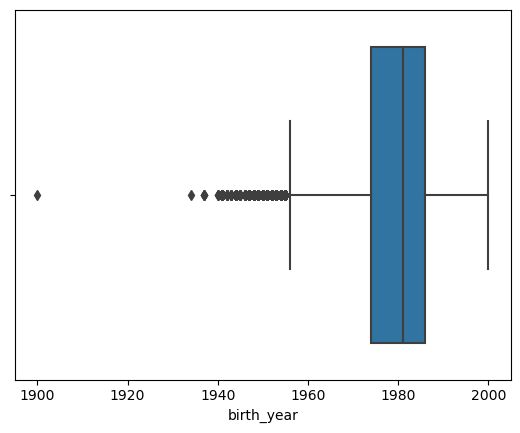

In [19]:
sns.boxplot(x=df_bike.birth_year)

As we can see above, the value of 1900 is an outlier. It will alter statistical analysis, so we will remove this record from the dataset.

In [20]:
# Remove an outlier
df_bike.index[df_bike['birth_year']==1900]
df_bike.drop([215055], inplace=True)

#### `trip_duration`

The company has a policy to limit a trip duration to 24 hours (86400 seconds). However, we have observed larger numbers that call for an investigation.

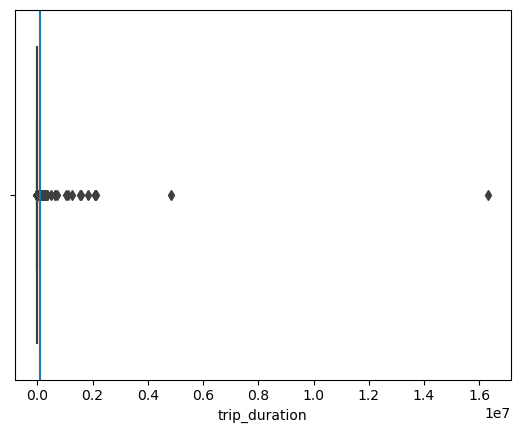

In [21]:
# Visualize the distribution of trip_duration with a vertical line at 24 hours (=86400 seconds)
sns.boxplot(x=df_bike.trip_duration)
plt.axvline(x=86400.0)
plt.show()

As we can see above, this is not the case of outlier(s). In order to alert the analysts for the further investigation, we will create a boolean column to flag riders whose trip exceeded 24 hours. 

In [22]:
# create a column to flag riders whose trip exceeded 24 hours. ('exceed_valid_trip_duration')
df_bike['exceed_trip_duration'] = df_bike['trip_duration'].apply(lambda x: 0 if x < 86400 else 1).astype(bool)

#### Handling Missing Data

In [23]:
# Replace values in 'gender' with null where the value is 0
df_bike['gender'] = np.where(df_bike['gender'] == 0, np.nan, df_bike['gender'])

In [24]:
df_bike.isna().sum()

trip_duration                  0
start_time                     0
stop_time                      0
start_station_id               0
start_station_name             0
start_station_latitude         0
start_station_longitude        0
end_station_id                 0
end_station_name               0
end_station_latitude           0
end_station_longitude          0
bike_id                        0
user_type                    380
birth_year                 18999
gender                     19901
id                             0
exceed_trip_duration           0
dtype: int64

We can observe above that `user_type` is missing less than 1% of the dataset. In contrast, `birth_year` and `gender` are missing around 10%. We will visualize the distribution of missing values for each variable to see if theses are MAR (missing at random) or not. 

<AxesSubplot:>

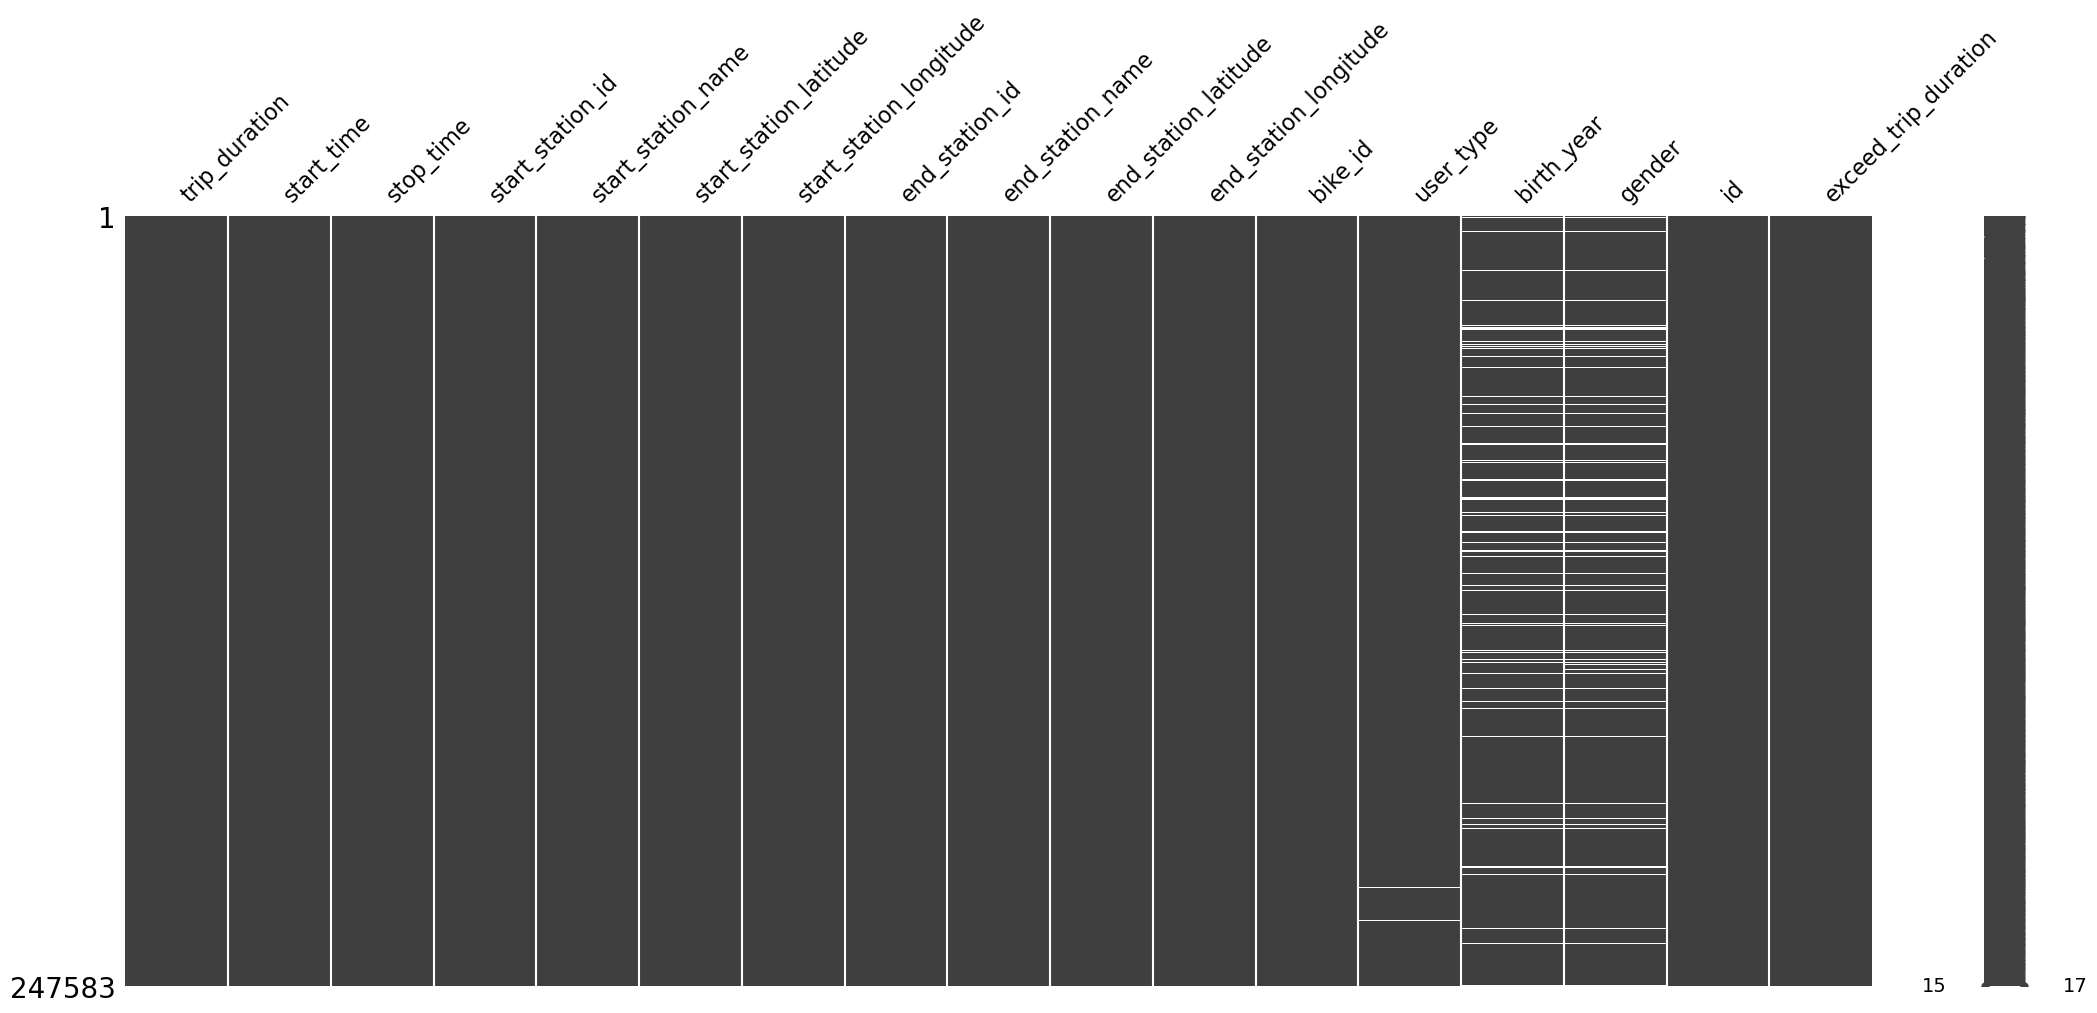

In [25]:
# Visualizing the distribution of missing values for each variable
msno.matrix(df_bike)

At a glance, `user_type` looks like MAR. We will also check the distribution of missingness throughout the time. 

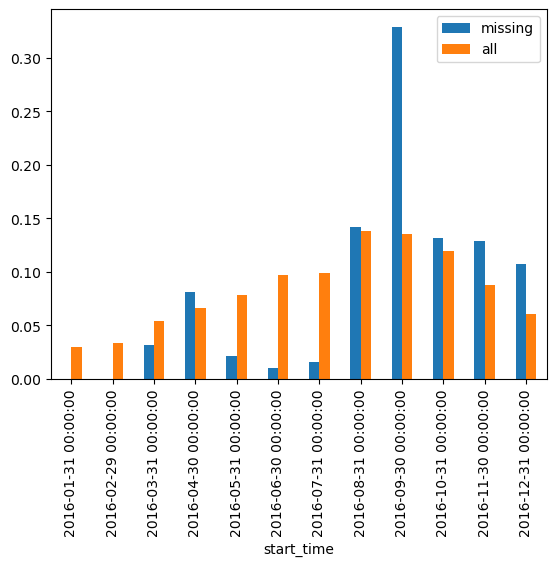

In [26]:
missing_user_type = df_bike[df_bike['user_type'].isnull()]
# the proportion of missing entries in 'user_type' for each month
missing_user_type_month = (missing_user_type.resample('M', on='start_time').count()['id'] / len(missing_user_type)).rename('missing')

# the proportion of all entries for each month
df_bike_month = (df_bike.resample('M', on='start_time').count()['id'] / len(df_bike)).rename('all')

missing_all_user_type = pd.concat([missing_user_type_month, df_bike_month], axis=1)
ax = missing_all_user_type.plot.bar()

After looking at the distribution of missing data in `user_type` throughout the time, we can see that this may not be MAR. We will retain the data by adding a `unknown` category. By keeping track of this issue, we can help the analytics team with future investigation. 

In [27]:
# Add 'unknown' cateogry for missing data in 'user_type'
df_bike.fillna({'user_type':'Unknown'},inplace=True)

On the other hand, the pattern of missingness is similar for `birth_year` and `gender`. This signals that they may be structually missing. We will take a closer look at these missing data before deciding what to do with them. 

In [28]:
missing_birth_year = df_bike[df_bike['birth_year'].isnull()]
missing_birth_year.head(10)

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,exceed_trip_duration
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,NaN,NaN,4,False
5,883,2016-01-01 01:03:28,2016-01-01 01:18:11,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24442,Customer,NaN,NaN,5,False
22,988,2016-01-01 03:16:33,2016-01-01 03:33:02,3196,Riverview Park,40.744319,-74.043991,3209,Brunswick St,40.724176,-74.050656,24662,Customer,NaN,NaN,22,False
53,3090,2016-01-01 11:07:15,2016-01-01 11:58:46,3203,Hamilton Park,40.727596,-74.044247,3203,Hamilton Park,40.727596,-74.044247,24444,Customer,NaN,NaN,53,False
57,788,2016-01-01 11:50:30,2016-01-01 12:03:39,3210,Pershing Field,40.742677,-74.051789,3195,Sip Ave,40.730743,-74.063784,24573,Customer,NaN,NaN,57,False
58,767,2016-01-01 11:50:43,2016-01-01 12:03:30,3210,Pershing Field,40.742677,-74.051789,3195,Sip Ave,40.730743,-74.063784,24678,Customer,NaN,NaN,58,False
59,682,2016-01-01 11:55:01,2016-01-01 12:06:24,3193,Lincoln Park,40.724605,-74.078406,3193,Lincoln Park,40.724605,-74.078406,24405,Customer,NaN,NaN,59,False
61,1886,2016-01-01 12:02:58,2016-01-01 12:34:25,3192,Liberty Light Rail,40.711242,-74.055701,3192,Liberty Light Rail,40.711242,-74.055701,24484,Customer,NaN,NaN,61,False
63,1667,2016-01-01 12:40:57,2016-01-01 13:08:44,3199,Newport Pkwy,40.728745,-74.032108,3199,Newport Pkwy,40.728745,-74.032108,24576,Customer,NaN,NaN,63,False
67,1410,2016-01-01 13:02:11,2016-01-01 13:25:41,3199,Newport Pkwy,40.728745,-74.032108,3185,City Hall,40.717732,-74.043845,24613,Customer,NaN,NaN,67,False


Looking at the first 10 rows of missing `birth_year` data, we can observe that `user_type` is all customers and `gender` is also missing. We will investigate if this pattern holds for the all missing data.

In [29]:
missing_birth_year['user_type'].value_counts(dropna=False)

Customer      15470
Subscriber     3529
Name: user_type, dtype: int64

In [30]:
missing_birth_year['user_type'].value_counts() / df_bike['user_type'].value_counts()

Customer      0.996714
Subscriber    0.015232
Unknown            NaN
Name: user_type, dtype: float64

In [31]:
missing_birth_year['gender'].value_counts(dropna=False)

NaN    18999
Name: gender, dtype: int64

We can observe that:
- more than 99% of customer `user_type` are missing `birth_year` while only 1.5% of subscriber `user_type` are missing `birth_year`.
- all records with missing `birth_year` are also missing `gender`. This likely corresponds to the customer `user_type`.

Since we cannot remove nearly all customer `user_type` data, we won't delete records that are missing `birth_year` or `gender`. While we retain null values for now, we will have to keep in mind that such demographic information is only useful for subscriers.

In [32]:
# Reset index as 'id'
df_bike.reset_index(drop=True,inplace=True)
df_bike['id'] = df_bike.index
df_bike.tail()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,exceed_trip_duration
247578,557,2016-12-31 23:10:16,2016-12-31 23:19:33,3214,Essex Light Rail,40.712774,-74.036486,3203,Hamilton Park,40.727596,-74.044247,24465,Subscriber,1981.0,2.0,247578,False
247579,2749,2016-12-31 23:29:39,2017-01-01 00:15:29,3183,Exchange Place,40.716247,-74.033459,3183,Exchange Place,40.716247,-74.033459,24389,Customer,NaN,NaN,247579,False
247580,173,2016-12-31 23:44:37,2016-12-31 23:47:31,3186,Grove St PATH,40.719586,-74.043117,3270,Jersey & 6th St,40.725289,-74.045572,24641,Subscriber,1978.0,1.0,247580,False
247581,2424,2016-12-31 23:44:50,2017-01-01 00:25:14,3214,Essex Light Rail,40.712774,-74.036486,3214,Essex Light Rail,40.712774,-74.036486,26219,Subscriber,1960.0,2.0,247581,False
247582,2419,2016-12-31 23:44:50,2017-01-01 00:25:10,3214,Essex Light Rail,40.712774,-74.036486,3214,Essex Light Rail,40.712774,-74.036486,24471,Subscriber,1956.0,1.0,247582,False


### Weather Data

For the weather data, we can observe the following:
- Record count is 366.
- There are 16 columns. Most of them can be renamed to make the data clearer for the analyst team. 
- There is only one value for both `STATION` and `NAME`. Unless we expect to source weather data from a different station, we can drop these columns.
- Columns `PGTM` and `TSUN` are entirely missing and will be dropped.
- As `WDFx` and `WSFx` refer to the fastest x-minute wind, they are difficult to connect to our data and analyze. Therefore, we will also drop these 4 columns. 

There is only one value for both `STATION` and `NAME`. Unless we expect to source weather data from a different station, we can drop these columns. Other columns such as `PGTM` and `TSUN` are entirely missing and will be dropped. As `WDFx` and `WSFx` refer to the fastest x-minute wind, they are difficult to connect to our data and analyze. Therefore, we will also drop these 4 columns. 

In [33]:
df_weather.isna().sum()

STATION      0
NAME         0
DATE         0
AWND         0
PGTM       366
PRCP         0
SNOW         0
SNWD         0
TAVG         0
TMAX         0
TMIN         0
TSUN       366
WDF2         0
WDF5         2
WSF2         0
WSF5         2
dtype: int64

In [34]:
# Drop 7 columns
df_weather.drop(['STATION', 'NAME', 'PGTM', 'TSUN', 'WDF2', 'WDF5', 'WSF2', 'WSF5'], axis=1, inplace=True)

In [35]:
df_weather.dtypes

DATE     object
AWND    float64
PRCP    float64
SNOW    float64
SNWD    float64
TAVG      int64
TMAX      int64
TMIN      int64
dtype: object

In [36]:
# Cast 'DATE' as timestamp 
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], yearfirst=True)

We will rename columns to make the data easier to undertand. 

In [37]:
# Rename columns 
df_weather.columns = ['date', 'avg_wind', 'prcp', 'snow_amount', 'snow_depth', 'tavg', 'tmax', 'tmin']

Finally, we will add some binary rain and snow columns to help analysts. 

In [38]:
# Create binary columns for rain, snow weather events
df_weather['rain'] = df_weather['prcp'].apply(lambda x: 1 if x > 0 else 0).astype(bool)
df_weather['snow'] = df_weather['snow_amount'].apply(lambda x: 1 if x > 0 else 0).astype(bool)

In [39]:
df_weather.head()

,date,avg_wind,prcp,snow_amount,snow_depth,tavg,tmax,tmin,rain,snow
0,2016-01-01,12.75,0.0,0.0,0.0,41,43,34,False,False
1,2016-01-02,9.40,0.0,0.0,0.0,36,42,30,False,False
2,2016-01-03,10.29,0.0,0.0,0.0,37,47,28,False,False
3,2016-01-04,17.22,0.0,0.0,0.0,32,35,14,False,False
4,2016-01-05,9.84,0.0,0.0,0.0,19,31,10,False,False


## Postgres Tables

### Dates Table
Our use-case and data both depend heavily on dates. Data granularity of the cleaned tables are different, as `df_bikes` has timestamps down to seconds and `df_weather` data record is recorded daily. Given the case scenario, we will then create a dedicated date dimension table with date, month, day, day name, and weekend information.

In [40]:
start = datetime.datetime(2016,1,1)
# Generate the remaining days of the year (leap year)
date_col = [start + datetime.timedelta(x) for x in range(366)]

# Create a dataframe
dates = pd.DataFrame(date_col, dtype='datetime64[ns]')
dates.columns = ['date']
dates.head()

,date
0,2016-01-01
1,2016-01-02
2,2016-01-03
3,2016-01-04
4,2016-01-05


In [41]:
# generate month, day, day name, and weekend information
dates['month'] = dates['date'].apply(lambda x: x.month)
dates['day'] = dates['date'].apply(lambda x: x.day)
dates['day_name'] = dates['date'].apply(lambda x: x.strftime('%A'))
dates['weekend'] = dates['day_name'].apply(lambda x: 1 if (x == 'Saturday' or x == 'Sunday') else 0).astype(bool)
dates.head()

,date,month,day,day_name,weekend
0,2016-01-01,1,1,Friday,False
1,2016-01-02,1,2,Saturday,True
2,2016-01-03,1,3,Sunday,True
3,2016-01-04,1,4,Monday,False
4,2016-01-05,1,5,Tuesday,False


We will also add a `date_key` as integer to all tables to make joining easier in the future.

In [42]:
# Create a primary key by transforming datetime objects to integers
dates['date_key'] = dates['date'].apply(lambda x: int(x.strftime('%Y%m%d').strip('-')))
df_bike['date_key'] = df_bike['start_time'].apply(lambda x: int(x.strftime('%Y%m%d').strip('-')))
df_weather['date_key'] = df_weather['date'].apply(lambda x: int(x.strftime('%Y%m%d').strip('-')))

# Reorder columns to move the last column to the first position 
dates = dates[[dates.columns[-1]] + list(dates.columns[:-1])]
dates.head()

,date_key,date,month,day,day_name,weekend
0,20160101,2016-01-01,1,1,Friday,False
1,20160102,2016-01-02,1,2,Saturday,True
2,20160103,2016-01-03,1,3,Sunday,True
3,20160104,2016-01-04,1,4,Monday,False
4,20160105,2016-01-05,1,5,Tuesday,False


### Trips Table

In [43]:
df_bike.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,exceed_trip_duration,date_key
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,Grove St PATH,40.719586,-74.043117,3209,Brunswick St,40.724176,-74.050656,24647,Subscriber,1964.0,2.0,0,False,20160101
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24605,Subscriber,1962.0,1.0,1,False,20160101
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24689,Subscriber,1962.0,2.0,2,False,20160101
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,Brunswick St,40.724176,-74.050656,3203,Hamilton Park,40.727596,-74.044247,24693,Subscriber,1984.0,1.0,3,False,20160101
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,NaN,NaN,4,False,20160101


In [44]:
trips = pd.DataFrame
trips_col = ['id', 'date_key', 'trip_duration', 'start_time', 'stop_time', 'start_station_id', 'end_station_id', 
             'bike_id', 'exceed_trip_duration']
trips = df_bike[trips_col]
trips.head()

,id,date_key,trip_duration,start_time,stop_time,start_station_id,end_station_id,bike_id,exceed_trip_duration
0,0,20160101,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,3209,24647,False
1,1,20160101,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,3213,24605,False
2,2,20160101,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,3213,24689,False
3,3,20160101,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,3203,24693,False
4,4,20160101,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,3210,24573,False


### Users Table

In [46]:
# create a users table with all the unique demographics in the df_bike dataset
users = pd.DataFrame
users = df_bike[['user_type','birth_year','gender']].drop_duplicates(subset=['user_type','birth_year','gender']).reset_index(drop=True)
users['user_id'] = users.index

# add user_id key to a trips table
trips = df_bike.merge(users, on=['user_type','birth_year','gender']).sort_values(by='id').reset_index(drop=True)

# drop the demographic info from the trips table
trips = trips.drop(['user_type','birth_year','gender'],axis=1)

trips.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,id,exceed_trip_duration,date_key,user_id
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,Grove St PATH,40.719586,-74.043117,3209,Brunswick St,40.724176,-74.050656,24647,0,False,20160101,0
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24605,1,False,20160101,1
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24689,2,False,20160101,2
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,Brunswick St,40.724176,-74.050656,3203,Hamilton Park,40.727596,-74.044247,24693,3,False,20160101,3
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,4,False,20160101,4


In [48]:
# change the name of user_id column in users table to id
users.rename(columns={'user_id':'id'}, inplace=True)
users = users[[users.columns[-1]] + list(users.columns[:-1])]
users.head()

,id,user_type,birth_year,gender
0,0,Subscriber,1964.0,2.0
1,1,Subscriber,1962.0,1.0
2,2,Subscriber,1962.0,2.0
3,3,Subscriber,1984.0,1.0
4,4,Customer,NaN,NaN


### Station Table

In [79]:
stations = pd.DataFrame
# Create two tables for start stations and end stations
start_stations = df_bike[['start_station_id','start_station_name','start_station_latitude','start_station_longitude']]
end_stations = df_bike[['end_station_id','end_station_name','end_station_latitude','end_station_longitude']]

# Rename columns for both tables to have the same column names
start_stations.columns = ['id', 'name', 'latitude', 'longitude']
end_stations.columns = ['id', 'name', 'latitude', 'longitude']

# Concatenate two tables into a DataFrame and drop duplicates
stations = pd.concat([start_stations, end_stations]).drop_duplicates()

# Rset the index
stations.reset_index(drop=True, inplace=True)

stations.head()

,id,name,latitude,longitude
0,3186,Grove St PATH,40.719586,-74.043117
1,3209,Brunswick St,40.724176,-74.050656
2,3195,Sip Ave,40.730743,-74.063784
3,3211,Newark Ave,40.721525,-74.046305
4,3187,Warren St,40.721124,-74.038051


### Weather Table

We can use `df_weather` table here.

In [80]:
weather = df_weather.copy()
weather['id'] = range(len(weather))
weather = weather[[weather.columns[-1]] + list(weather.columns[:-1])]
weather.head()

,id,date,avg_wind,prcp,snow_amount,snow_depth,tavg,tmax,tmin,rain,snow,date_key
0,0,2016-01-01,12.75,0.0,0.0,0.0,41,43,34,False,False,20160101
1,1,2016-01-02,9.40,0.0,0.0,0.0,36,42,30,False,False,20160102
2,2,2016-01-03,10.29,0.0,0.0,0.0,37,47,28,False,False,20160103
3,3,2016-01-04,17.22,0.0,0.0,0.0,32,35,14,False,False,20160104
4,4,2016-01-05,9.84,0.0,0.0,0.0,19,31,10,False,False,20160105


## Create a Database

In [91]:
username = "postgres"
host = "localhost"
port = "5432"
database_name = "bike_rental"
password = "postgres"

# Construct the DATABASE_URL 
DATABASE_URL = f"postgresql://{username}:{password}@{host}:{port}/{database_name}"

# Create a SQLAlchemy engine
engine = create_engine(DATABASE_URL)
con = engine.connect()

# dates.to_sql('dates', con, if_exists='append',index=False,chunksize=10000)
# stations.to_sql('stations', con, if_exists='append',index=False,chunksize=10000)
trips.to_sql('trips', con, if_exists='append',index=False,chunksize=10000)
users.to_sql('users', con, if_exists='append',index=False,chunksize=10000)
weather.to_sql('weather', con, if_exists='append',index=False,chunksize=10000)

con.close()